In [1]:
%matplotlib notebook

In [17]:
import matplotlib.pyplot as plt
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = ['Linux Libertine']
import numpy as np
import itertools

On se propose de résoudre un problème aux limites de Dirichlet
$$
\begin{cases}
-\Delta u + \lambda u = f & \text{dans }\Omega = (0,L)^2 \\
u = 0 &\text{sur }\partial\Omega
\end{cases}
$$

Sa formulation variationnelle est
$$\forall \phi\in V_0,\quad
\int_\Omega \nabla u\cdot\nabla\phi + \lambda\int_\Omega u\phi = \int_\Omega f\phi
$$
où $V_0 := \{v\in\mathcal C^1(\Omega)\,\mid\, \phi=0\text{ et }\partial\Omega\} $ une fonction test.

In [159]:
L = 1
N = 50
dx = L/N
xrange = np.linspace(0,L,N+1)
yrange = xrange.copy().reshape(-1,1)

In [160]:
def phi(x,n=None):
    if n is None:
        return np.maximum(0,1 - np.absolute(x))
    else:
        return phi((x-xrange[n])/dx)

Donc, avec une solution $u(x,y) = \sum_{i=0}^N u_{i,j}\phi_i(x)\phi_j(y)$,
$$
\sum_{i=0}^N u_{i,j} \int_\Omega (\nabla(\phi_i\otimes\phi_j)\cdot\nabla(\phi_k\otimes\phi_l) + \lambda (\phi_i\otimes\phi_j)(\phi_k\otimes\phi_l)) = \int_\Omega f\phi_k\otimes\phi_l
$$

Remarquons que $\nabla(\phi_i\otimes\phi_j)\cdot\nabla(\phi_k\otimes\phi_l) = \phi_i'(x)\phi_k'(x)\phi_j(y)\phi_l(y) + \phi_i(x)\phi_k(x)\phi_j'(y)\phi_l'(y)$.

Définissons la matrice de rigidité $\mathcal K_h = \left(\int_0^L\phi_i'\phi_k' \right)_{i,k}$ et la matrice de masse $\mathcal M_h = \left(\int_0^L \phi_i\phi_k\right)_{i,k}$.

Le système linéaire ci-dessus se réécrit donc
$$
\forall k,l\in\{0,\ldots,N\}\quad
\sum_{i,j} u_{i,j}(\mathcal K_{i,k}\mathcal M_{j,l} + \mathcal M_{i,k}\mathcal K_{j,l} + \lambda\mathcal M_{i,k}\mathcal M_{j,l} ) = F_{k,l}
$$

On remplace $U\in\mathbb R^{N+1}$ par $\tilde U\in\mathbb R^{N+1}$ avec $\tilde u_{i+Nj} = u_{i,j}$. Idem pour $F$.

La matrice associée sera $A$ où $A_{i+Nj,k+Nl} = \mathcal K_{i,k}\mathcal M_{j,l} + \mathcal M_{i,k}\mathcal K_{j,l} + \mathcal M_{i,k}\mathcal M_{j,l}$.

On note $\phi(x) = \max(0,1-|x|)$ et
$$
\phi_i(x) = \phi\left(\frac{x-x_i}{h}\right).
$$

La matrice de rigidité $\mathcal K_h$ est une matrice de Toeplitz:

In [161]:
from scipy.linalg import toeplitz
rigidx = (1/dx)*toeplitz([2,-1] + [0 for _ in range(N-1)])

La matrice de masse $\mathcal M_h$ est aussi tridiagonale:

In [162]:
massex = dx*toeplitz([2/3,1/6] + [0 for _ in range(N-1)])

In [163]:
import numba

In [164]:
@numba.jit(nopython=True)
def make_A(lmbda):
    A = np.zeros(((N+1)**2,(N+1)**2))
    for i in range(N+1):
        for j in range(N+1):
            for k in range(N+1):
                for l in range(N+1):
                    A[i+(N+1)*j,k+(N+1)*l] = massex[i,k]*rigidx[j,l] + rigidx[i,k]*massex[j,l] + lmda*massex[i,k]*massex[j,l]
    return A

On définit une fonction réalisant une méthode des trapèzes:
$$
\int_a^b g(x)\,dx \approx \frac{b-a}{p+1} \left(
\frac 12\left(g(a) + g(b)\right) +
\sum_{k=0}^p \left(g(x_{k-1})+g(x_{k+1})\right)
\right)
$$

In [166]:
def quad_trapz(g,a,b,p):
    step = (b-a)/(p+1)
    first_term = 0.5*(g(a)+g(b))
    second_term = np.sum(g(a+k*step) for k in range(1,p))
    return step*(first_term + second_term)

In [167]:
def coeffs_from_f(f):
    res = []
    
    p = 4
    res.append(quad_trapz(lambda x: f(x)*phi(x,0),xrange[0],xrange[1],p))
    for n in range(1,N):    
        res.append(
            quad_trapz(lambda x: f(x)*phi(x,n),xrange[n-1],xrange[n+1],p)
        )
    res.append(quad_trapz(lambda x: f(x)*phi(x,N),xrange[N-1],xrange[N],p))
    return np.array(res)

La fonction suivante définit la fonction f du second membre, sous la forme
$$
f(x,y) = f_1\otimes f_2
$$

In [197]:
def make_f():
    import sympy as sp
    from sympy.abc import x
    expr1 = sp.exp(x)
    expr2 = sp.cos(x**2)
    return (sp.lambdify(x, expr1,["numpy"]), 
            sp.lambdify(x, expr2,["numpy"]))
f,g = make_f()
coeffsF = coeffs_from_f(f)
coeffsG = coeffs_from_f(g)

coeffsF_bis = np.zeros((N+1)**2)
for i in range(N+1):
    for j in range(N+1):
        coeffsF_bis[i+(N+1)*j] = coeffsF[i]*coeffsG[j]

In [198]:
def matricisize(M):
    U = np.zeros((N+1,N+1))
    for p in range(M.size):
        i = p%(N+1)
        j = p//(N+1)
        U[i,j] = M[p]
    return U

In [201]:
def recon_f(x,y):
    return np.sum(phi(x,n)*phi(y,m)*f(xrange[n])*g(yrange[m]) for (n,m) in itertools.product(range(N+1),range(N+1)))

def graphe(lmda):
    A = make_A(lmda)
    
    fig = plt.figure(0,figsize=(8,4))
    ax0 = fig.add_subplot(121)
    ax1 = fig.add_subplot(122)
    
    ax0.set_title(r'Solution approchée $u_h$')
    ax1.set_title(r'Approximation de $f$ par éléments $\mathrm{\mathbb{P}}_1$')
    
    U = np.linalg.solve(A,coeffsF_bis)
    coeffsU = matricisize(U)
    
    def u(x,y):
        return np.sum(phi(x,n)*phi(y,m)*coeffsU[n,m] for (n,m) in itertools.product(range(N+1),range(N+1)))
    
    im0 = ax0.imshow(u(xrange,yrange),extent=[0,L,0,L])
    im1 = ax1.imshow(recon_f(xrange,yrange),extent=[0,L,0,L])

<IPython.core.display.Javascript object>


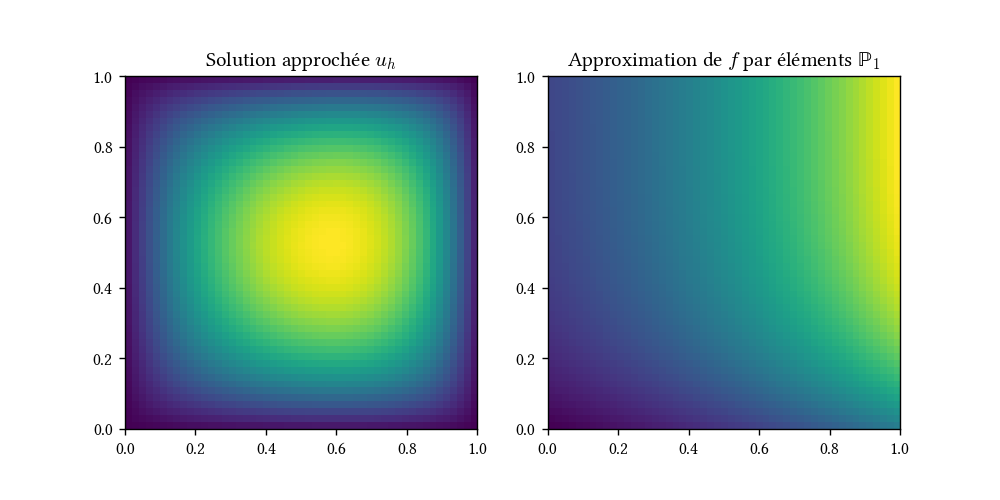

In [202]:
graphe(-10)